# FStrings

Esta tabla contiene la información adicional de las sentencias de tipo JoinedStr (Strings formateados).  --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

full_table = get_data('fstrings')

# Table name, features and target.
TABLE_NAME = 'fstrings'
TABLE_FEATURES = ['fstring__number_of_elements', 'fstring__constants_pct', 'fstring__expressions_pct', 'fstring__expertise_level']
TABLE_TARGET = 'fstring__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. For each instance we have {X.shape[1]} attributes.')

2024-06-02 11:44:55.323198 Data cache files found ...
2024-06-02 11:44:55.328228 Data cache files successfully loaded!!
Features shape: (22030, 4)
Target shape: (22030,)
As we can see the downloaded data contains a total of 22030 instances. For each instance we have 4 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22030 entries, 0 to 22029
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fstring__number_of_elements  22030 non-null  int64  
 1   fstring__constants_pct       22030 non-null  float64
 2   fstring__expressions_pct     22030 non-null  float64
 3   fstring__expertise_level     22030 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 688.6+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 22030 entries, 0 to 22029
Series name: fstring__expertise_level
Non-Null Count  Dtype 
--------------  ----- 
22030 non-null  object
dtypes: object(1)
memory usage: 172.2+ KB
None


Cómo podemos ver la tabla está compuesta por 3 variables numéricas y 1 de tipo objeto.

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 22.59% instances for BEGINNER class and 77.41% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [99.63%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

fstring__number_of_elements    0
fstring__constants_pct         0
fstring__expressions_pct       0
fstring__expertise_level       0
dtype: int64

In [6]:
print_empty_cols(X)

fstring__number_of_elements
---------------------------
0 instancias no tienen un valor para la columna fstring__number_of_elements


fstring__constants_pct
----------------------
0 instancias no tienen un valor para la columna fstring__constants_pct


fstring__expressions_pct
------------------------
0 instancias no tienen un valor para la columna fstring__expressions_pct


fstring__expertise_level
------------------------
0 instancias no tienen un valor para la columna fstring__expertise_level




### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fstring__number_of_elements,22030.0,NaN,NaN,NaN,3.17222,1.990383,0.0,2.0,3.0,4.0,44.0
fstring__constants_pct,22030.0,NaN,NaN,NaN,0.554332,0.154877,0.0,0.5,0.5,0.666667,1.0
fstring__expressions_pct,22030.0,NaN,NaN,NaN,0.445623,0.154861,0.0,0.333333,0.5,0.5,1.0
fstring__expertise_level,22030,2,EXPERT,17053,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "fstring__number_of_elements": [(0.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 0.0 max:44.0
    "fstring__constants_pct": [(0.0, 0.5), (0.5, 0.5), (0.5, 0.67), (0.67, inf)],  # min: 0.0 max: 1.0
    "fstring__expressions_pct": [(0.0, 0.33), (0.33, 0.5), (0.5, 0.5), (0.5, inf)],  # min: 0.0 max: 1.0
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['fstring__number_of_elements'], 10))
print(get_statistics(X_copy, ['fstring__constants_pct'], 10))
print(get_statistics(X_copy, ['fstring__expressions_pct'], 10))


# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['module__function_defs_pct', 'module__number_of_classes'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
fstring__number_of_elements  count  percentage
                  [2.0_3.0)   8303   37.689514
                  [3.0_4.0)   6279   28.502043
                  [4.0_inf]   5997   27.221970
                  [0.0_2.0)   1451    6.586473

fstring__constants_pct  count  percentage
             [0.5_0.5]  11364   51.584203
            [0.5_0.67)   7748   35.170222
             [0.0_0.5)   1825    8.284158
            [0.67_inf]   1093    4.961416

fstring__expressions_pct  count  percentage
               [0.5_0.5]  11364   51.584203
              [0.33_0.5)   7748   35.170222
               [0.5_inf]   1824    8.279619
              [0.0_0.33)   1094    4.965956

--- TWO FEATURES ---
--- THREE FEATURES ---


In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (22030, 5)
Target shape: (22030,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

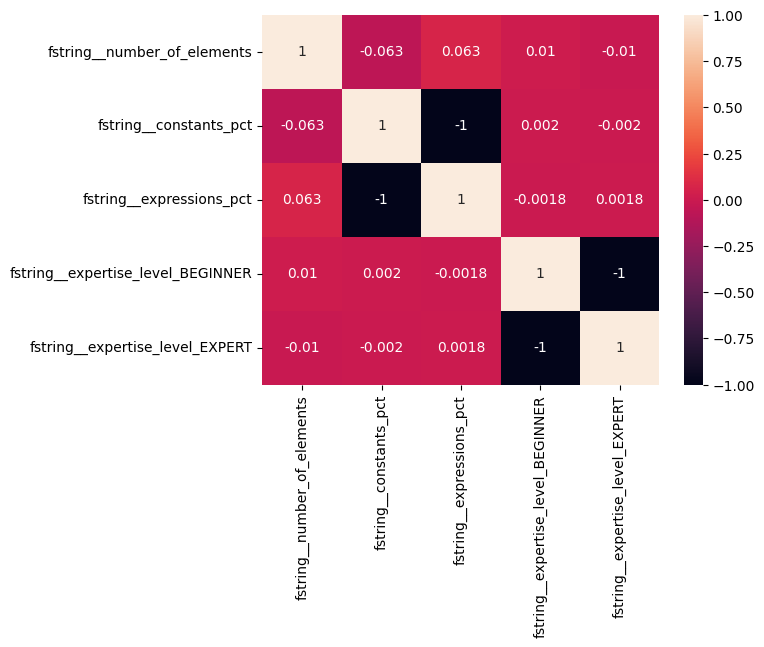

In [10]:
sns.heatmap(X.corr(), annot=True)

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 3 variables (1 numerica y 2 porcentuales) se hara un analisis detallado

### Variable number_of_elements (1/3)
Esta variable representa el número de elementos del JoinedStr. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 44. Con una media de 3.17.

<Axes: ylabel='fstring__number_of_elements'>

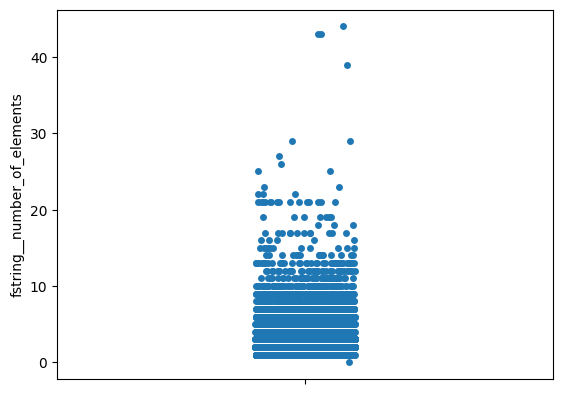

In [11]:
sns.stripplot(X['fstring__number_of_elements'])

In [12]:
print_outliers_for_df_column(X, 'fstring__number_of_elements')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8437512625347484
Rango valores atípicos extremos (Tukey): [-4.0,10.0]
Rango valores atípicos leves (Tukey): [-1.0,7.0]
Rango valores atípicos extremos (Fixed BoxPlot): [1.8434714926819817,91.67329410490808]
-3.0IQR: 0 instancias tienen un valor para fstring__number_of_elements inferior a -4.0 (Q1-3*IQR) para fstring__number_of_elements. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para fstring__number_of_elements inferior a -1.0 (Q1-1.5*IQR) para fstring__number_of_elements. Representando un 0.0% del total de instancias.
+1.5IQR: 625 instancias tienen un valor para fstring__number_of_elements superior a 7.0 (Q3+1.5*IQR) para fstring__number_of_elements. Representando un 2.837% del total de instancias.
+3.0IQR: 211 instancias tienen un valor para fstring__number_of_elements superior a 10.0 (Q3-3*IQR) para fstring__number_of_elements. Representando un 0.9578% del total de instancias.
L: 14

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 10.0 (Con un MC de 84 usamos Tuckey Extremo)

In [13]:
X[X['fstring__number_of_elements'] > 10].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,fstring__number_of_elements,fstring__constants_pct,fstring__expressions_pct,fstring__expertise_level_BEGINNER,fstring__expertise_level_EXPERT
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,14.872038,0.514283,0.485717,0.227488,0.772512
std,5.394682,0.032567,0.032566,0.420207,0.420207
min,11.000000,0.333333,0.454545,0.000000,0.000000
25%,12.000000,0.500000,0.461538,0.000000,1.000000
50%,13.000000,0.523810,0.476190,0.000000,1.000000
75%,16.000000,0.538462,0.500000,0.000000,1.000000
max,44.000000,0.545455,0.666667,1.000000,1.000000


### Variable constants_pct (2/3)
Esta variable representa la proporción de los valores usados para parametrizar el JoinedStr que son constantes. Toma los valores de 0.0 - 1.0. La media es 0.555.

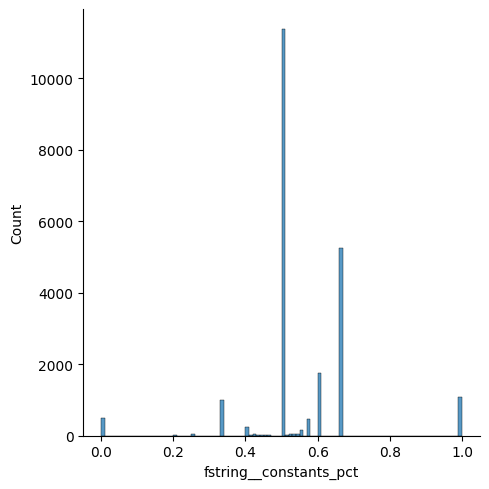

In [14]:
sns.displot(X['fstring__constants_pct'], bins=[i / 100 for i in range(0, 101)])

In [15]:
print_outliers_for_df_column(X, 'fstring__constants_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.3964905666705379
Rango valores atípicos extremos (Tukey): [-5.960464477539063e-08,1.1666667461395264]
Rango valores atípicos leves (Tukey): [0.2499999701976776,0.916666716337204]
Rango valores atípicos extremos (Fixed BoxPlot): [0.4375888432337415,1.887664036531831]
-3.0IQR: 0 instancias tienen un valor para fstring__constants_pct inferior a -5.960464477539063e-08 (Q1-3*IQR) para fstring__constants_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 492 instancias tienen un valor para fstring__constants_pct inferior a 0.2499999701976776 (Q1-1.5*IQR) para fstring__constants_pct. Representando un 2.233% del total de instancias.
+1.5IQR: 1093 instancias tienen un valor para fstring__constants_pct superior a 0.916666716337204 (Q3+1.5*IQR) para fstring__constants_pct. Representando un 4.961% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para fstring__constants_pct superior a 1.1666667461395264 (Q3-3*IQR) p

Describimos los valores de las variables de la tabla, cuando el valor de la variable es menor de 0.249 o mayor que 0.917 (Con un MC de 39 usamos Tuckey)

In [16]:
X[(X['fstring__constants_pct'] < 0.249) | (X['fstring__constants_pct'] > 0.917)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,fstring__number_of_elements,fstring__constants_pct,fstring__expressions_pct,fstring__expertise_level_BEGINNER,fstring__expertise_level_EXPERT
count,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000
mean,1.149527,0.691172,0.308197,0.206309,0.793691
std,0.633434,0.460776,0.460513,0.404783,0.404783
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000
max,9.000000,1.000000,1.000000,1.000000,1.000000


### Variable expressions_pct (3/3)
Esta variable representa la proporción de valores usados para parametrizar el JoinedStr que son expresiones. Toma los valores de 0.0 - 1.0. La media es 0.444.

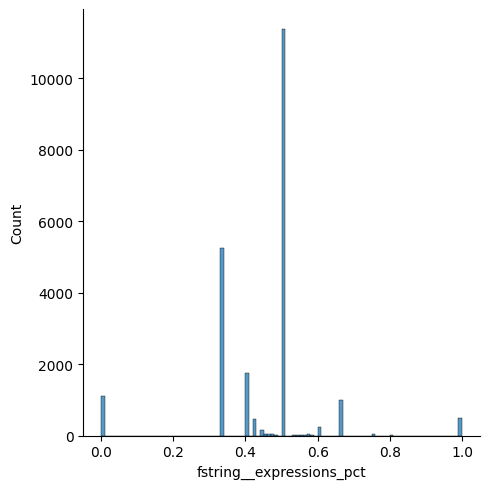

In [17]:
sns.displot(X['fstring__expressions_pct'], bins=[i / 100 for i in range(0, 101)])

In [18]:
print_outliers_for_df_column(X, 'fstring__expressions_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.027188509702682495
Rango valores atípicos extremos (Tukey): [-0.16666662693023682,0.9999999701976776]
Rango valores atípicos leves (Tukey): [0.08333335816860199,0.7499999850988388]
Rango valores atípicos extremos (Fixed BoxPlot): [0.10602644609895254,0.7787220077400476]
-3.0IQR: 0 instancias tienen un valor para fstring__expressions_pct inferior a -0.16666662693023682 (Q1-3*IQR) para fstring__expressions_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 1094 instancias tienen un valor para fstring__expressions_pct inferior a 0.08333335816860199 (Q1-1.5*IQR) para fstring__expressions_pct. Representando un 4.966% del total de instancias.
+1.5IQR: 491 instancias tienen un valor para fstring__expressions_pct superior a 0.7499999850988388 (Q3+1.5*IQR) para fstring__expressions_pct. Representando un 2.229% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para fstring__expressions_pct superior a 0.99999997019

Describimos los valores de las variables de la tabla, cuando el valor de la variable es menor de 0.084 o mayor que 0.749

In [19]:
X[(X['fstring__expressions_pct'] < 0.084) | (X['fstring__expressions_pct'] > 0.749)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,fstring__number_of_elements,fstring__constants_pct,fstring__expressions_pct,fstring__expertise_level_BEGINNER,fstring__expertise_level_EXPERT
count,1624.00000,1624.000000,1624.000000,1624.000000,1624.000000
mean,1.21798,0.680578,0.318807,0.201970,0.798030
std,0.76299,0.460192,0.459950,0.401594,0.401594
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,0.000000,0.000000,0.000000,1.000000
50%,1.00000,1.000000,0.000000,0.000000,1.000000
75%,1.00000,1.000000,1.000000,0.000000,1.000000
max,9.00000,1.000000,1.000000,1.000000,1.000000


## Multivariate

TODO: isolation forest algorithm

In [20]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,fstring__number_of_elements,fstring__constants_pct,fstring__expressions_pct,fstring__expertise_level
